In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = list(colors.values())
greys = sns.color_palette('Greys', 6)

plt.style.use('style.mpl')

In [2]:
# Load E. coli growth rates from Schmidt et al. 2016
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
mask = np.logical_and(
    coli_data.dataset.str.contains('schmidt'),
    coli_data.growth_mode != 'chemostat') 
stress_conds = 'pH6,osmotic_stress_glucose,42C'.split(',')
mask = np.logical_and(mask, ~coli_data.condition.isin(stress_conds))
coli_csource_df = coli_data[mask].sort_values('growth_rate_hr')
coli_csource_df.condition.replace({'glycerol_pAA': 'glycerol + AA', 'lb_miller': 'rich (LB)'}, inplace=True)

In [3]:
# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

# Load biomass macromolecular composition from Bremer & Dennis 2008
biomass_percent_df = pd.read_csv('../data/physiology/BremerDennis2008_BiomassComposition_pct.csv', index_col=0)

In [4]:
# Load model sensitivity analyses
phi_df = pd.read_csv('../output/fix_lambda.csv')
var_ZCred_df = pd.read_csv('../output/fix_ZCred.csv')
var_phi_red_df = pd.read_csv('../output/fix_phi_red.csv')
var_ZCB_df = pd.read_csv('../output/fix_ZCorg_ZCB.csv')

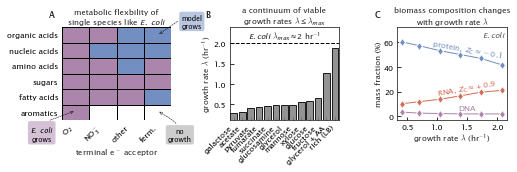

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7.24, 2.5))
        
# Panel on range of metabolic modes. 
plt.sca(axs[0])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('terminal e$^-$ acceptor')

# annotate the growth/non-growth with plt.annotate using same coordinates and positions as figtext
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="arc,angleA=90,armA=10,rad=10",
    linestyle='--',
    facecolor='black', edgecolor='black', lw=0.5)
bbox = dict(boxstyle="round", fc=colors['purple'], ec="w", lw=0, alpha=0.5)
plt.annotate('$E.$ $coli$\ngrows', xy=(0.5, 5.4), xytext=(0.08, 0.17), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)
bbox = dict(boxstyle="round", fc=colors['blue'], ec="w", lw=0, alpha=0.5)
plt.annotate('model\ngrows', xy=(3.5, 0.5), xytext=(0.368, 0.8), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)
bbox = dict(boxstyle="round", fc=greys[-2], ec="w", lw=0, alpha=0.3)
plt.annotate('no\ngrowth', xy=(3.5, 5.4), xytext=(0.345, 0.17), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)

# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[1])
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right')# , fontsize=6)
plt.ylim(0.1, 2.4)
plt.text(6, 2.03, '$E. coli$ $\lambda_{max} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=8)

plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xlabel('')

plt.sca(axs[2])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

labels = ["protein, $Z_{\mathrm{C}} \\approx -0.1$", 
          "RNA, $Z_{\mathrm{C}} \\approx +0.9$",
          "DNA"]
lcolors = ['blue', 'red', 'purple']
locs = [(1.5, 54, -10), (1.5, 23, 10), (1.5, 7, 0)]
for label, c, loc in zip(labels, lcolors, locs):
    x,y,rotation = loc
    plt.text(x, y, label, ha='center', va='center', color=colors[c],
             transform=plt.gca().transData, rotation=rotation, fontsize=8)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=plt.gca().transAxes,
         ha='right', va='top', color=greys[-2], fontsize=8)


titles = ["metabolic flexbility of\nsingle species like $E.$ $coli$",
          "a continuum of viable\ngrowth rates $\lambda \leq \lambda_{max}$",
          "biomass composition changes\nwith growth rate $\lambda$"]
for ax, title in zip(axs, titles):
    ax.set_title(title)

label_pos = [(0.1, 0.88), (0.40, 0.88), (0.725, 0.88)]
for (x,y), label in zip(label_pos, 'ABC'):
    plt.figtext(x, y, label, fontsize=8, weight='bold')

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='white', dpi=300)
plt.show()

[-1.11022302e-16]


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_26450/776085064.py:125: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_26450/776085064.py:128: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('../output/Fig1_old.png', facecolor='white', dpi=300)
/opt/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


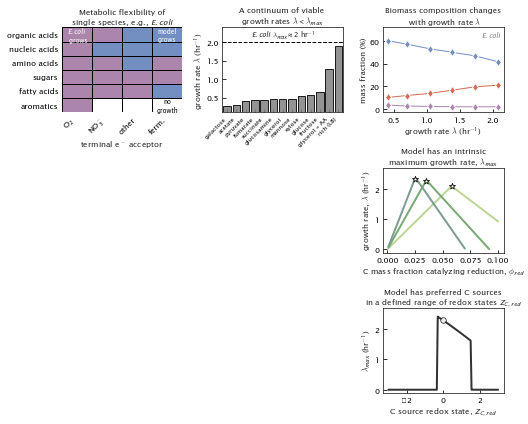

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 6), 
                        gridspec_kw={'width_ratios': [1, 1, 1],
                                     'height_ratios': [1, 1, 1]})

for i in range(1,3):
    for j in range(0,2):
        plt.sca(axs[i, j])
        plt.axis('off')
        
# Panel on range of metabolic modes. 
plt.sca(axs[0,0])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.title('Metabolic flexibility of\n single species, e.g., $E. coli$')
plt.text(0.5, 0.5, '$E. coli$\n grows', ha='center', va='center', fontsize=6.3, color='w')
plt.text(3.5, 0.5, 'model\ngrows', ha='center', va='center', fontsize=6.3, color='w')
plt.text(3.5, 5.5, 'no\ngrowth', ha='center', va='center', fontsize=6.3, color='k')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('terminal e$^-$ acceptor')

# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[0,1])
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.ylim(0.1, 2.4)
plt.title('A continuum of viable \ngrowth rates $\lambda < \lambda_{max}$')
plt.text(6, 2.03, '$E. coli$ $\lambda_{max} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=7)

plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xlabel('')

plt.sca(axs[0, 2])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.title('Biomass composition changes\n with growth rate $\lambda$')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=plt.gca().transAxes, ha='right', va='top',
         fontsize=7, color='grey')

# Panels deriving from new model.
plt.sca(axs[1,2])
mask = var_phi_red_df.S4.isin([0.5, 1.0, 1.5])
masked = var_phi_red_df[mask]
pal = [colors[c] for c in 'light_green,green,dark_green'.split(',')]
sns.lineplot(data=masked,
             x='reduction_phi',
             y='lambda_hr',
             hue='S4',
             palette=pal,
             legend=False)

max_idxs = masked.groupby('S4').lambda_hr.idxmax().values
sns.scatterplot(data=masked.loc[max_idxs],
                x='reduction_phi',
                y='lambda_hr',
                color='w', marker='*', s=40, edgecolor='k',
                lw=0.75, zorder=10, legend=False)
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.xlabel(r'C mass fraction catalyzing reduction, $\phi_{red}$')
plt.ylim(-0.1, 2.7)

plt.sca(axs[2,2])
ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 5, ]]
print(my_ZCBs)
pal = sns.color_palette('Greys_r', n_colors=5)
for i, zcb in enumerate(my_ZCBs):
    mask = var_ZCB_df['ZCB'] == zcb
    masked = var_ZCB_df[mask]

    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))

# Highlight points where ZCred = ZCB
mask = np.logical_and(
    var_ZCB_df.ZCB.isin(my_ZCBs),
    (var_ZCB_df.ZCB - var_ZCB_df.ZCorg).abs() < 0.01)
mask = np.logical_and(mask, var_ZCB_df['opt.max_phi_H_set'] == True)
sns.scatterplot(data=var_ZCB_df[mask],
                x='ZCorg',
                y='lambda_hr',
                color='w', marker='o',
                s=30, edgecolor='k', alpha=0.9,
                lw=0.75, zorder=10, legend=False)

#plt.legend(loc=2) 
plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('C source redox state, $Z_{C,red}$')  
plt.ylim(-0.1, 2.7)

titles = [
    'Model has an intrinsic\nmaximum growth rate, $\lambda_{max}$',
    'Model has preferred C sources\nin a defined range of redox states $Z_{C,red}$',
]
for title, ax in zip(titles, axs[1:,-1]):
    ax.set_title(title)

plt.tight_layout() 
#plt.tight_layout(h_pad=0.2)
#plt.subplots_adjust(hspace=0.75)
plt.savefig('../output/Fig1_old.png', facecolor='white', dpi=300)
plt.show()

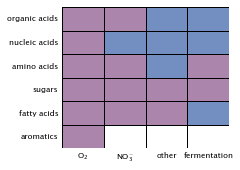

In [7]:
plt.figure(figsize=(3, 2.6))
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'fermentation'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=0, ha='center')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('')
plt.savefig('../output/Fig1A_presentation.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

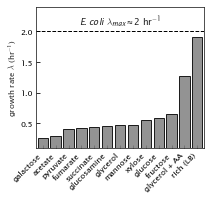

In [8]:
plt.figure(figsize=(3,2.6))
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 2.4)
plt.text(6, 2.03, '$E. coli$ $\lambda_{max} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=9)

plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xlabel('')
plt.savefig('../output/Fig1B_presentation.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

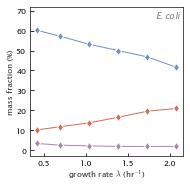

In [9]:
# Presentation version of Fig 1C
plt.figure(figsize=(2.75,2.75))
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=plt.gca().transAxes, ha='right', va='top',
         fontsize=9, color='grey')

plt.savefig('../output/Fig1C_presentation.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# TODO: rename files to reflect current figure numbers
var_S4_df = pd.read_csv('../output/fix_ZCorg_S4.csv')
var_S3_df = pd.read_csv('../output/fix_ZCorg_S3.csv')
var_ZCB_df = pd.read_csv('../output/fix_ZCorg_ZCB.csv')

In [11]:
mask = np.logical_and(var_S4_df.lambda_hr > 0.001,
                      var_S4_df['opt.max_phi_H_set'] == True)
masked = var_S4_df[mask]
max_ZCred_by_S4 = masked.groupby('S4').agg({'ZCorg': 'max'})
min_ZCred_by_S4 = masked.groupby('S4').agg({'ZCorg': 'min'})
max_lambda_by_S4 = masked.groupby('S4').agg({'lambda_hr': 'max'})
min_lambda_by_S4 = masked.groupby('S4').agg({'lambda_hr': 'min'})

ZCred_range_by_S4 = max_ZCred_by_S4 - min_ZCred_by_S4

# make a data frame from the above
ZCred_range_by_S4.columns = ['ZCred_range']
ZCred_range_by_S4['max_lambda_hr'] = max_lambda_by_S4
ZCred_range_by_S4['min_lambda_hr'] = min_lambda_by_S4
ZCred_range_by_S4 = ZCred_range_by_S4.reset_index()

# Fit a line to the ZCred_range vs. max lambda
tradeoff_reg = linregress(ZCred_range_by_S4.ZCred_range, ZCred_range_by_S4.max_lambda_hr)

0.0001
estimated lambda_max: 2.592
actual lambda_max: 2.28702680515414


NameError: name 'zcorg_sensitivity_df' is not defined

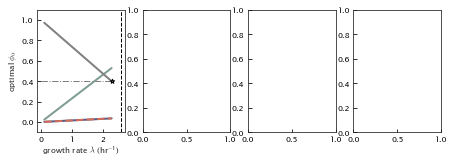

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(7.24, 2.25))
pal = sns.color_palette('Greys_r', n_colors=5)
greens = sns.color_palette('Greens_r', n_colors=5, desat=0.3)

# Panels deriving from new model.
plt.sca(axs[0])

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
print(g_ana)
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal $\phi_\alpha$')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[1])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.axvspan(-2.1, 2, color='grey', alpha=0.15, zorder=-10)

#plt.legend(loc=1)
ZCred_xlabel = 'C source redox state, $Z_{C,red}$'
plt.xlabel(ZCred_xlabel)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(np.arange(0, 2.91, 1))
plt.ylim(-0.1, 2.91)
plt.ylabel(r'$\lambda_{max}$ (hr$^{-1}$)')

# Variable ZCB
plt.sca(axs[2])
ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 1, 5, 9, ]]
print(my_ZCBs)
pal = sns.color_palette('Greys_r', n_colors=5)
for i, zcb in enumerate(my_ZCBs):
    mask = var_ZCB_df['ZCB'] == zcb
    masked = var_ZCB_df[mask]

    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))

# Highlight points where ZCred = ZCB
mask = np.logical_and(
    var_ZCB_df.ZCB.isin(my_ZCBs),
    (var_ZCB_df.ZCB - var_ZCB_df.ZCorg).abs() < 0.01)
mask = np.logical_and(mask, var_ZCB_df['opt.max_phi_H_set'] == True)
sns.scatterplot(data=var_ZCB_df[mask],
                x='ZCorg',
                y='lambda_hr',
                color='w', marker='o',
                s=30, edgecolor='k', alpha=0.9,
                lw=0.75, zorder=10, legend=False)

#plt.legend(loc=2) 
plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel(ZCred_xlabel)  
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(np.arange(0, 2.91, 1))
plt.ylim(-0.1, 2.91)

# Variable S4 = respiratory ATP yield
plt.sca(axs[3])

sns.scatterplot(data=ZCred_range_by_S4,
                x='ZCred_range',
                y='max_lambda_hr',
                color='grey', marker='o',
                s=20, edgecolor='k', alpha=0.5,
                lw=0.75, zorder=10, legend=False)
xs = np.linspace(1.65, 2.15, 100)
ys = tradeoff_reg.slope*xs + tradeoff_reg.intercept
plt.plot(xs, ys, color='k', ls='--', lw=1)
plt.xlim(1.65, 2.15)
plt.yticks(np.arange(2.3, 2.41, 0.1))
plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('width of feasible $Z_{C,red}$ range')

#my_S4s = [0.5, 1, 1.5]
#for i, S4 in enumerate(my_S4s):
#    masked = var_S4_df[var_S4_df['S4'] == S4]

#   phi_H_included = masked[
#        masked['opt.max_phi_H_set'] == False]
#    no_phi_H = masked[
#        masked['opt.max_phi_H_set'] == True]
#    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_4$ = {0:.1f}'.format(S4))
#    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

#plt.ylim(-0.1, 2.7)
#plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
#plt.xlabel(ZCred_xlabel)
#plt.legend(loc=2)

# Set titles
titles = [
    'Model has a $\lambda_{max}$ arising\n when $\phi_O$ is minimized',
    'Metabolic flexibility has a\ncost that reduces $\lambda_{max}$',
    'Matching biomass redox ($Z_{C,B}$)\nto food ($Z_{C,red}$) improves growth',
    'An intrinsic tradeoff between\nflexibility and $\lambda_{max}$',
]
for title, ax in zip(titles, axs):
    ax.set_title(title)
  
plt.tight_layout(h_pad=0.2)
plt.savefig('../output/Fig2_old.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

0.0001
estimated lambda_max: 2.592
actual lambda_max: 2.28702680515414


/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_26450/1008178995.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


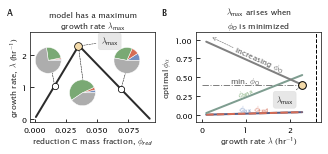

In [13]:
# Figure about constraints on growth rates
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.75, 2.25))

# lambda as a function of phi_red
plt.sca(axs[0])
#mask = var_phi_red_df.S4.isin([0.5, 1.0, 1.5])
mask = var_phi_red_df.S4 == 1.0
masked = var_phi_red_df[mask]
pal = [colors[c] for c in 'light_green,green,dark_green'.split(',')]
sns.lineplot(data=masked,
             x='reduction_phi',
             y='lambda_hr', color=greys[-1],
             legend=False)

# show pie charts for select points
phi_names = 'oxidation_phi,reduction_phi,anabolism_phi,phi_O'.split(',')
low_phi_red = masked.iloc[15]
low_phi_red.lambda_hr
hi_phi_red = masked.iloc[-24]
hi_phi_red.lambda_hr
max_phi_red = masked.loc[masked.lambda_hr.idxmax()]
plt.scatter([low_phi_red.reduction_phi, hi_phi_red.reduction_phi],
            [low_phi_red.lambda_hr, hi_phi_red.lambda_hr], 
            color='w', marker='o', s=40, edgecolor='k', 
            lw=0.75, zorder=10)

max_idxs = masked.groupby('S4').lambda_hr.idxmax().values
lambda_max = masked.loc[max_idxs].lambda_hr.max()
phi_red_argmax = masked.loc[max_idxs].reduction_phi.values[0]
sns.scatterplot(data=masked.loc[max_idxs],
                x='reduction_phi',
                y='lambda_hr',
                color=colors['light_yellow'], marker='o', s=60, edgecolor='k',
                lw=0.75, zorder=10, legend=False)

# annotate the point where lambda_max is found
bbox = dict(boxstyle="round", fc=greys[1], ec=greys[1], lw=0.5, alpha=0.5)
arrowprops = dict(
    arrowstyle="-", linestyle='--', 
    facecolor=greys[-1], edgecolor=greys[-1], lw=0.5)
plt.annotate('$\lambda_{\mathrm{max}}$', xy=(phi_red_argmax, lambda_max), xytext=(phi_red_argmax+0.025, lambda_max+0.15),
             textcoords='data', fontsize=8, ha='center', va='center', color=greys[-1],
             annotation_clip=False, arrowprops=arrowprops, bbox=bbox)

plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.xlabel(r'reduction C mass fraction, $\phi_{red}$')
plt.ylim(-0.1, 2.7)

# make an inset pie charts
inset_ax_positions = [
    [0.07, 0.5, 0.2, 0.2],
    [0.17, 0.3, 0.2, 0.2],
    [0.3, 0.5, 0.2, 0.2],
]
cs = [colors[c] for c in 'blue,red,green'.split(',')] + [greys[2]]
arrowprops = dict(
    arrowstyle="-", linestyle='--',
    facecolor='black', edgecolor='black', lw=0.5)
for i, phi_series in enumerate([low_phi_red, max_phi_red, hi_phi_red]):
    inset_pos = inset_ax_positions[i]
    ax_inset = fig.add_axes(inset_pos)
    phis = phi_series[phi_names].values
    assert round(phis.sum()) == 1.0
    ax_inset.pie(phis, colors=cs, wedgeprops=dict(lw=0.5, edgecolor='w'))

# reset the current axis to the main plot so we can use its coordinates
plt.sca(axs[0])
inset_center_pos_data = [
    (0.0125, 1.75),
    (0.04, 0.8),
    (0.075, 1.75),
]
for i, phi_series in enumerate([low_phi_red, max_phi_red, hi_phi_red]):
    # use annotate() to draw arrows from insets to points on the main plot
    bbox = dict(boxstyle="round,pad=0", fc="w", ec="w", lw=0, alpha=0)
    xy = phi_series.reduction_phi, phi_series.lambda_hr
    xytext = inset_center_pos_data[i]
    plt.annotate('', xy=xy, xytext=xytext,
                 textcoords='data', xycoords='data',
                 arrowprops=arrowprops, zorder=-1)

# phis as a function of lambda
plt.sca(axs[1])

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
print(g_ana)
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['light_yellow'], edgecolor='k', marker='o', zorder=10, s=60)

labels = ["min. $\phi_{\mathrm{O}}$", "$\phi_{\mathrm{ana}}$", 
          "$\phi_{\mathrm{ox}}$", "$\phi_{\mathrm{red}}$"]
lcolors = [greys[-2], colors['green'], colors['blue'], colors['red']]
locs = [(1, 0.45, 0), (1, 0.3, 26), (1, 0.085, 3), (1.35, 0.086, 3)]
for label, c, loc in zip(labels, lcolors, locs):
    x,y,rotation = loc
    plt.text(x, y, label, ha='center', va='center', color=c,
             transform=plt.gca().transData, rotation=rotation, fontsize=8)

# use annotate to draw an arrow towards the top-left from the increasing phi_o label
bbox = dict(boxstyle="round,pad=0", fc="w", ec="w", lw=0, alpha=0)
arrowprops = dict(
    arrowstyle="->", linestyle='--', 
    facecolor=greys[-2], edgecolor=greys[-2], lw=0.5)
plt.annotate('increasing $\phi_{\mathrm{O}}$', xy=(0.2, 1.04), xytext=(1.3, 0.73), textcoords='data', rotation=-24,
             fontsize=8, ha='center', va='center', color=greys[-2], annotation_clip=True, arrowprops=arrowprops, bbox=bbox)

# annotate the point where lambda_max is found
bbox = dict(boxstyle="round", fc=greys[1], ec=greys[1], lw=0.5, alpha=0.5)
arrowprops = dict(
    arrowstyle="-", linestyle='--', 
    facecolor=greys[-1], edgecolor=greys[-1], lw=0.5)
plt.annotate('$\lambda_{\mathrm{max}}$', xy=(lambda_max, min_phi_O), xytext=(lambda_max-0.4, min_phi_O-0.2), textcoords='data',
             fontsize=8, ha='center', va='center', color=greys[-1], annotation_clip=False, arrowprops=arrowprops, bbox=bbox)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
#plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal $\phi_\alpha$')   
#plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

titles = [
    'model has a maximum\ngrowth rate $\lambda_{\mathrm{max}}$',
    '$\lambda_{\mathrm{max}}$ arises when\n$\phi_O$ is minimized',
]
for title, ax in zip(titles, axs):
    ax.set_title(title)

plt.figtext(0.05, 0.88, 'A', fontsize=8, weight='bold')
plt.figtext(0.50, 0.88, 'B', fontsize=8, weight='bold')

plt.tight_layout()
plt.savefig('../output/Fig3_growth_rate.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.sca(axs[2])
ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 5, ]]
print(my_ZCBs)
pal = sns.color_palette('Greys_r', n_colors=5)
for i, zcb in enumerate(my_ZCBs):
    mask = var_ZCB_df['ZCB'] == zcb
    masked = var_ZCB_df[mask]

    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))

# Highlight points where ZCred = ZCB
mask = np.logical_and(
    var_ZCB_df.ZCB.isin(my_ZCBs),
    (var_ZCB_df.ZCB - var_ZCB_df.ZCorg).abs() < 0.01)
mask = np.logical_and(mask, var_ZCB_df['opt.max_phi_H_set'] == True)
sns.scatterplot(data=var_ZCB_df[mask],
                x='ZCorg',
                y='lambda_hr',
                color='w', marker='o',
                s=30, edgecolor='k', alpha=0.9,
                lw=0.75, zorder=10, legend=False)
# approx range of ZCred values for coli C sources. 
plt.axvspan(-2.1, 2, color=greys[-3], alpha=0.15, zorder=-10)

plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('C source redox state, $Z_{\mathrm{C,red}}$')  
plt.ylim(-0.1, 2.7)
plt.text(-1.3, 0.15, "no\ngrowth", color=colors['red'], ha='center', fontsize=8)
plt.text(2.4, 0.15, "no\ngrowth", color=colors['red'], ha='center', fontsize=8)
plt.text(-1.3, 1.3, "more\nreduced", color=greys[-1], ha='center', fontsize=8)
plt.text(2.4, 1.3, "more\noxidized", color=greys[-1], ha='center', fontsize=8)
plt.text(2.9, 2.3, "$Z_{\mathrm{C,B}} = Z_{\mathrm{C,red}}$", color=greys[-1], ha='right', fontsize=8)

IndexError: index 2 is out of bounds for axis 0 with size 2

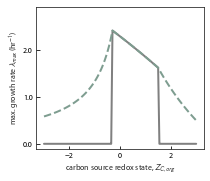

In [ ]:
# Presentation version of Fig. 2B 
plt.figure(figsize=(3, 2.6))
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline model'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

#plt.axvspan(-2.1, 2, color='grey', alpha=0.15, zorder=-10)

#plt.legend(loc=1)
ZCred_xlabel = 'carbon source redox state, $Z_{C,org}$'
plt.xlabel(ZCred_xlabel)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(np.arange(0, 2.91, 1))
plt.ylim(-0.1, 2.91)
plt.ylabel(r'max. growth rate $\lambda_{max}$ (hr$^{-1}$)')

plt.savefig('../output/Fig2B_presentation_homeo.png', facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
var_phi_O_df = pd.read_csv('../output/fix_phi_O.csv')
var_phi_red_df = pd.read_csv('../output/fix_phi_red.csv')
var_g_ana_df = pd.read_csv('../output/fix_g_ana.csv')
var_g_red_df = pd.read_csv('../output/fix_g_red.csv')

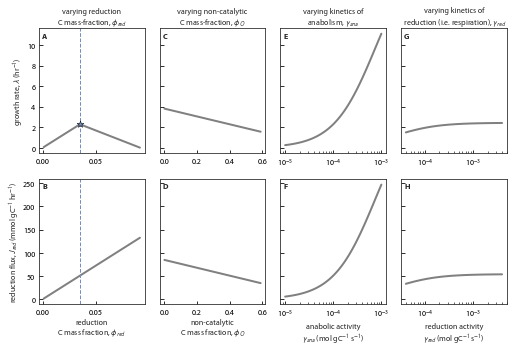

In [ ]:
# Supplementary figure focusing on respiratory rates
# TODO: add variable stoichiometry, e.g. S4, to these panels
# TODO: calculate CUE and plot that as well
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(7.24, 5), sharey='row')
flat_axs = axs.flatten(order='F')

# Left panel: varying phi_red
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,0])
# File was made with variable S4 -- use default value of 1 ATP/e-
mask = var_phi_red_df.S4 == 1.0
masked_phi_red_df = var_phi_red_df[mask]

max_idx = masked_phi_red_df.lambda_hr.idxmax()
plt.plot(masked_phi_red_df.reduction_phi, masked_phi_red_df.lambda_hr, color='grey')
plt.scatter(masked_phi_red_df.reduction_phi[max_idx], masked_phi_red_df.lambda_hr[max_idx],
            color=colors['blue'], marker='*', zorder=10, s=50, edgecolor='k', lw=0.5)
plt.axvline(masked_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'growth rate, $\lambda$ (hr$^{-1}$)')
plt.title('varying reduction\nC mass-fraction, $\phi_{red}$')
plt.sca(axs[1,0])
plt.plot(masked_phi_red_df.reduction_phi, masked_phi_red_df.reduction_flux*3.6e6,
         color='grey')
plt.axvline(masked_phi_red_df.reduction_phi[max_idx], color=colors['blue'], ls='--', lw=1)
plt.ylabel(r'reduction flux, $J_{red}$ (mmol gC$^{-1}$ hr$^{-1}$)')
plt.xlabel('reduction\nC mass fraction, $\phi_{red}$')

# Left panel: varying phi_O
# Model can use ATP homeostasis to maximize growth
plt.sca(axs[0,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying non-catalytic\nC mass-fraction, $\phi_O$')
plt.sca(axs[1,1])
plt.plot(var_phi_O_df.phi_O, var_phi_O_df.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('non-catalytic\nC mass fraction, $\phi_O$')

# Middle panels: varying anabolism gamma
# TODO: narrow range here so growth rates don't balloon as much
mask = var_g_ana_df['opt.max_phi_H_set'] == False
masked = var_g_ana_df[mask]

plt.sca(axs[0,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\nanabolism, $\gamma_{ana}$')
plt.sca(axs[1,2])
plt.xscale('log')
plt.plot(masked.anabolism_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('anabolic activity\n$\gamma_{ana}$ (mol gC$^{-1}$ s$^{-1}$)')

# Right panels: varying anabolism gamma
mask = var_g_red_df['opt.max_phi_H_set'] == False
masked = var_g_red_df[mask]

plt.sca(axs[0, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.lambda_hr, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.title('varying kinetics of\n reduction (i.e. respiration), $\gamma_{red}$')
plt.sca(axs[1, 3])
plt.xscale('log')
plt.plot(masked.reduction_gamma, masked.reduction_flux*3.6e6, color='grey', label=r'$\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.xlabel('reduction activity\n$\gamma_{red}$ (mol gC$^{-1}$ s$^{-1}$)')

for label, ax in zip("ABCDEFGH", flat_axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=9, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('../output/FigSX_max_Jred.png', facecolor='white', bbox_inches='tight', dpi=300)

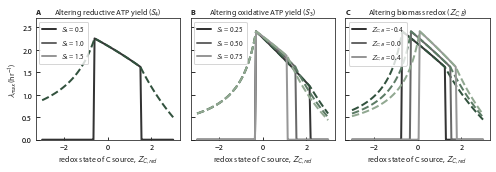

In [ ]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 2.5), sharey=True)
pal = sns.color_palette('Greys_r', n_colors=5)
greens = sns.color_palette('Greens_r', n_colors=5, desat=0.3)
flat_axs = axs.flatten()

# Variable S4 = respiratory ATP yield
plt.sca(axs[0])
plt.title('Altering reductive ATP yield ($S_4$)')

my_S4s = [0.5, 1, 1.5]
for i, S4 in enumerate(my_S4s):
    masked = var_S4_df[var_S4_df['S4'] == S4]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_4$ = {0:.1f}'.format(S4))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# Variable S3 = oxidative ATP yield
plt.sca(axs[1])
plt.title('Altering oxidative ATP yield ($S_3$)')

my_S3s = [0.25, 0.5, 0.75]
for i, S3 in enumerate(my_S3s):
    masked = var_S3_df[var_S3_df['S3'] == S3]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$S_3$ = {0:.2f}'.format(S3+0))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# Variable ZCB
plt.sca(axs[2])
plt.title('Altering biomass redox ($Z_{C,B}$)')

ZCBs = np.array(sorted(var_ZCB_df.ZCB.unique()))
my_ZCBs = ZCBs[[ 1, 5, 9, ]]
for i, zcb in enumerate(my_ZCBs):
    mask = var_ZCB_df['ZCB'] == zcb
    masked = var_ZCB_df[mask]

    phi_H_included = masked[
        masked['opt.max_phi_H_set'] == False]
    no_phi_H = masked[
        masked['opt.max_phi_H_set'] == True]
    plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color=pal[i], label='$Z_{{C,B}}$ = {0:.1f}'.format(zcb+1e-6))
    plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, color=greens[i], ls='--')

plt.legend(loc=2) 
plt.xlabel('redox state of C source, $Z_{C,red}$')  
plt.ylim(0, 2.7)

for label, ax in zip("ABCDEFGH", flat_axs):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_model_change_stoich.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Enzymology figures
enz_data = pd.read_csv('../data/enzymes/BarEven2011_compact_kinetics.csv')
enz_data.head(4)

,EC1,EC2,EC3,EC4,compound_ID,reaction_ID,direction,organism_ID,publication_ID,T,pH,KM_uM,kcat_s,module_ID,module_name,module_type
0,1,1,1,1,84,754,1,7,2819000,NaN,NaN,3400.0,NaN,NaN,NaN,NaN
1,1,1,1,1,84,754,1,7,6395900,NaN,NaN,85.0,NaN,NaN,NaN,NaN
2,1,1,1,1,84,754,1,8,6354100,NaN,NaN,217.0,NaN,NaN,NaN,NaN
3,1,1,1,1,84,754,1,9,3282500,NaN,NaN,2830.0,NaN,NaN,NaN,NaN


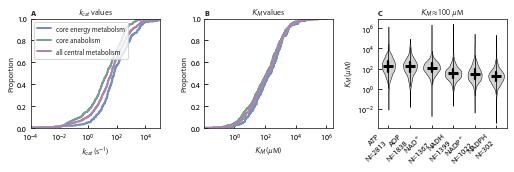

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(7.24, 2.5))
flat_axs = axs.flatten()

notnull = enz_data.kcat_s.notnull()
mask_primary_energy = np.logical_and(
    notnull, enz_data.module_type == 'Primary - Carbohydrate & Energy Metabolism')
mask_primary_biosyn = np.logical_and(
    notnull, enz_data.module_type == 'Primary - amino acids, fatty acids and nucleotides')
mask_primary_all = np.logical_or(mask_primary_energy, mask_primary_biosyn)
mask_secondary = np.logical_and(
    notnull, enz_data.module_type == 'Secondary')

sub_dfs = [enz_data[mask] for mask in [mask_primary_energy, mask_primary_biosyn, mask_primary_all]]
names = ['core energy metabolsm', 'core anabolism', 'all central metabolism']

# kcat plot
plt.sca(axs[0])
plt.xscale('log')
my_pal = [colors['blue'], colors['dark_green'], colors['purple']]
for i, (df, name) in enumerate(zip(sub_dfs, names)):
    sns.ecdfplot(df.kcat_s, label=name, color=my_pal[i])
    plt.xlabel('$k_{cat}$ (s$^{-1}$)')
plt.legend(loc=2, fontsize=7)
plt.title('$k_{cat}$ values')
plt.xlim((1e-4, 1e5))

# KM plot
plt.sca(axs[1])
plt.xscale('log')
for i, (df, name) in enumerate(zip(sub_dfs, names)):
    sns.ecdfplot(df.KM_uM, label=name, color=my_pal[i])
    plt.xlabel('$K_{M}}$ ($\mu$M)')
plt.title('$K_M$ values')

plt.sca(axs[2])
cpds = {
    2: 'ATP',
    8: 'ADP',
    3: 'NAD$^+$',
    4: 'NADH',
    6: 'NADP$^+$',
    5: 'NADPH',
}
cpd_order = list(cpds.keys())
sub_df = enz_data[enz_data.compound_ID.isin(cpds.keys())].copy()
sub_df['log_KM_uM'] = np.log10(sub_df.KM_uM)
counts = sub_df.groupby('compound_ID').agg({'KM_uM':'count'}).values.T[0].tolist()
medians = sub_df.groupby('compound_ID').agg({'KM_uM':'median', 'log_KM_uM':'median'})

@FuncFormatter
def my_formatter(x, pos):
     return r"10$^{{{0:0.0f}}}$".format(x)

greys = sns.color_palette('Greys', 6)
sns.violinplot(data=sub_df, x='compound_ID', y='log_KM_uM',
               order=cpd_order, color=greys[1], edgecolor='k', linewidth=0.5)
sns.stripplot(data=medians, x=medians.index, y='log_KM_uM', marker='_', s=10,
              order=cpd_order, color='k', linewidth=3, jitter=0)

xs = np.arange(6)
labels = [cpds[i] for i in cpd_order]
labels = ['{0}\nN={1}'.format(l, n) for l,n in zip(labels, counts)]
plt.xticks(xs, labels, rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('$K_M$ ($\mu$M)')
plt.gca().yaxis.set_major_formatter(my_formatter)

plt.title('$K_M \\approx 100$ $\\mu$M')

for label, ax in zip("ABCDEFGH", flat_axs):
    plt.sca(ax)
    plt.title(label, loc='left', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_enzyme_kinetics.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()